# Music genre prediction

## Вводная информация

### Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
        
# !pip install catboost
# !pip install feature-engine
# !pip install imbalanced-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score, classification_report)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler

from catboost import CatBoostClassifier
from sklearn.utils import resample, shuffle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures
from sklearn.experimental import enable_iterative_imputer  # Enable IterativeImputer
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from imblearn.combine import SMOTETomek

In [52]:
try:
    train = pd.read_csv('kaggle_music_genre_train.csv')
except:
    train = pd.read_csv('/kaggle/input/the-kaggle-music-prediction-competition/kaggle_music_genre_train.csv')


In [4]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [6]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,20394.0,55973.846916,20695.792545,20011.00000,38157.25000,56030.000000,73912.750000,91758.000
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,220375.425272,126728.326142,-1.00000,177517.00000,219533.000000,266000.000000,4497994.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [8]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [9]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

7

In [10]:
train = train.drop_duplicates()

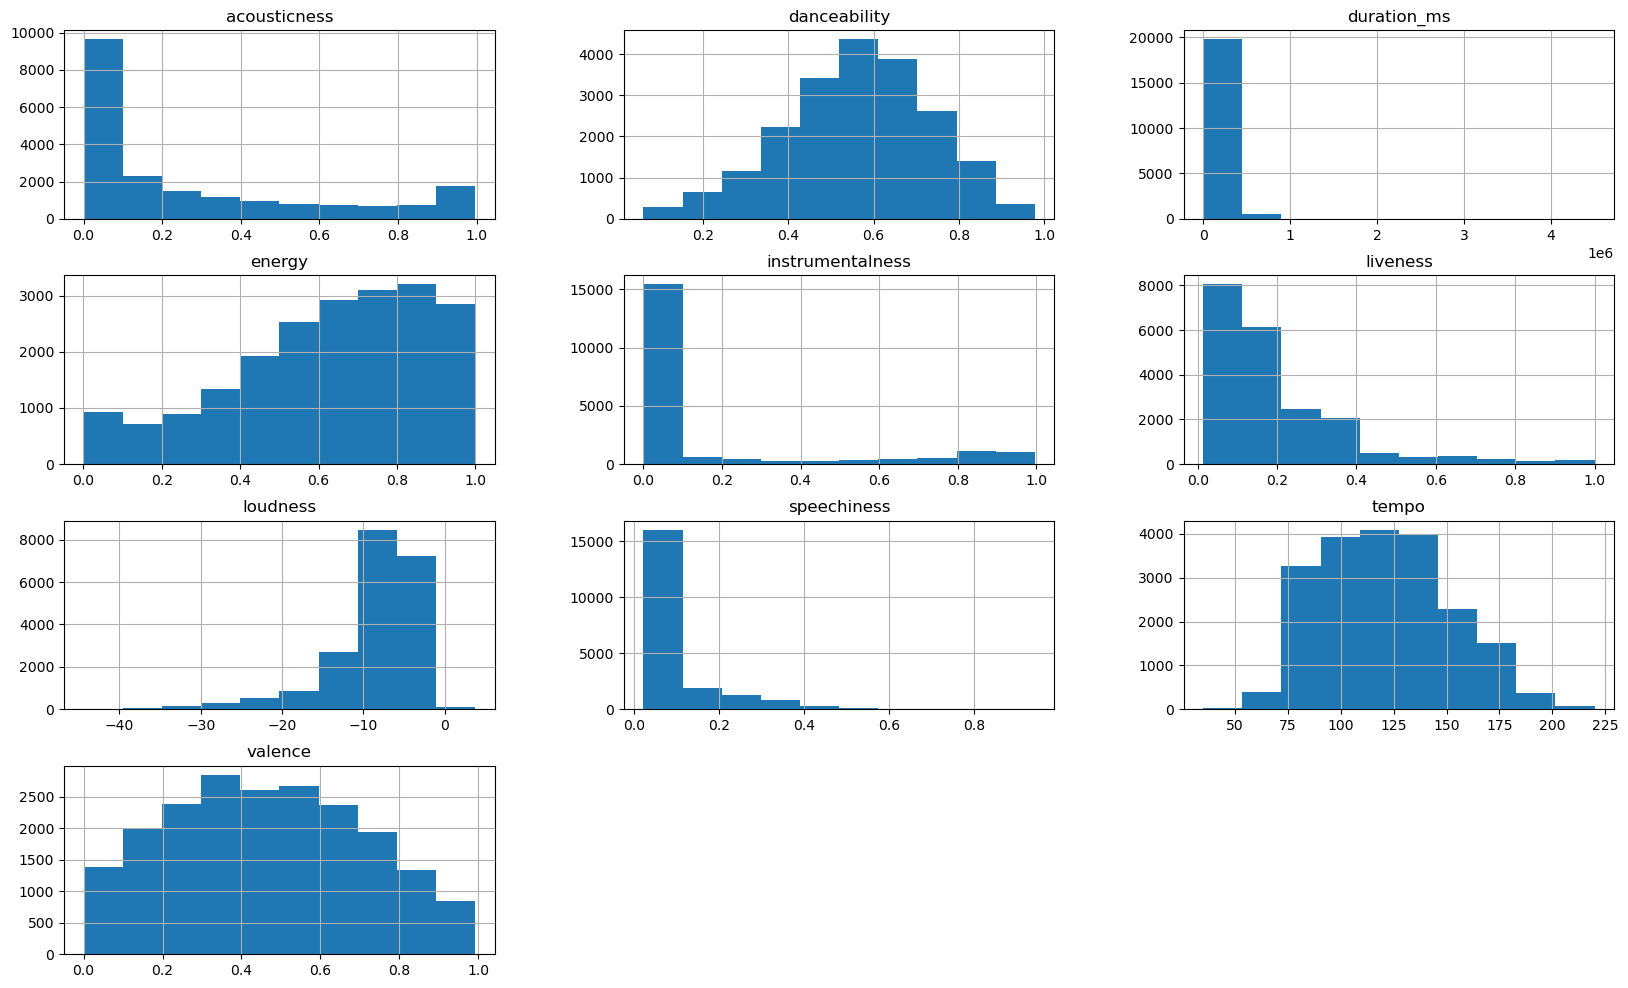

In [11]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

In [12]:
phik_overview = train.phik_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


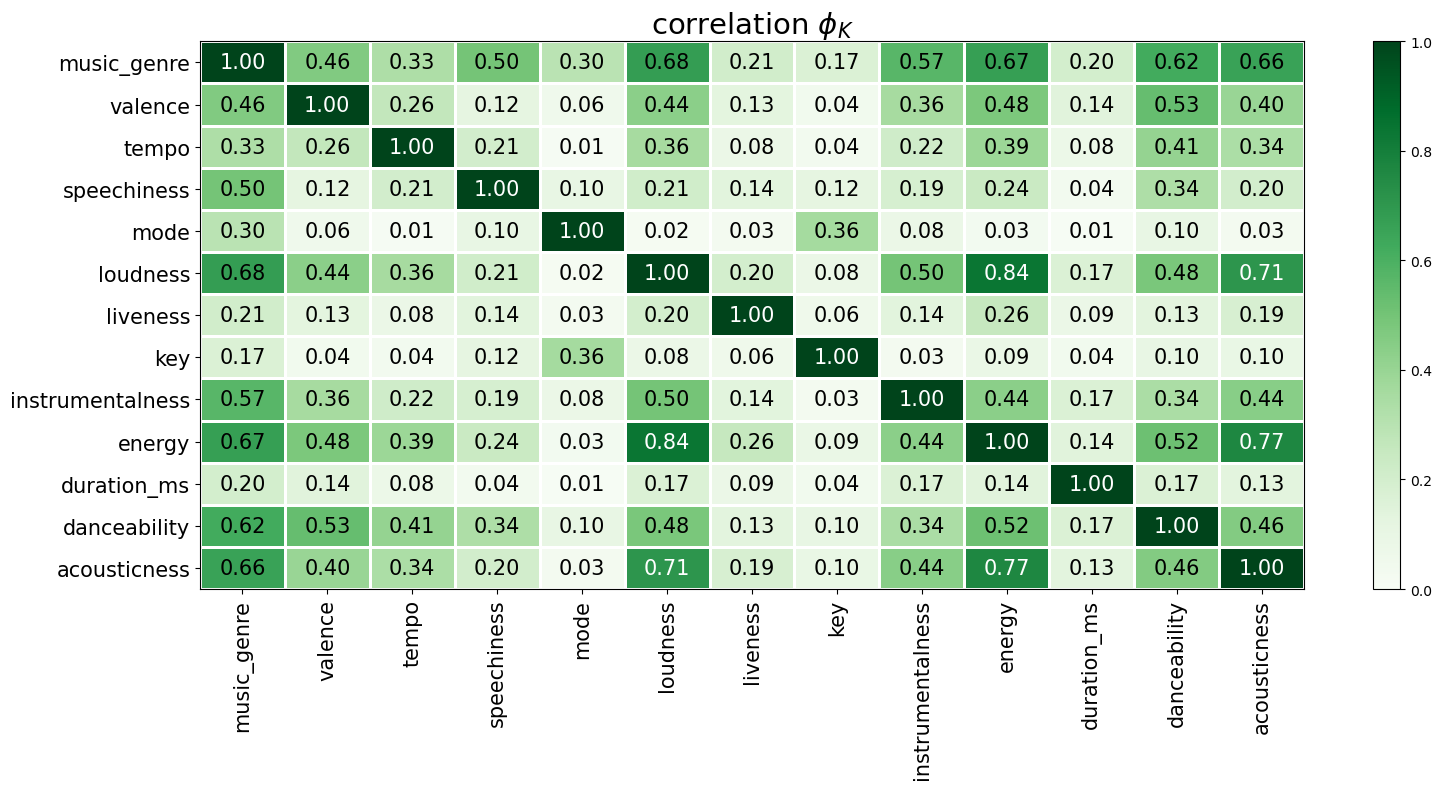

In [13]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [14]:
significance_overview = train.significance_matrix() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


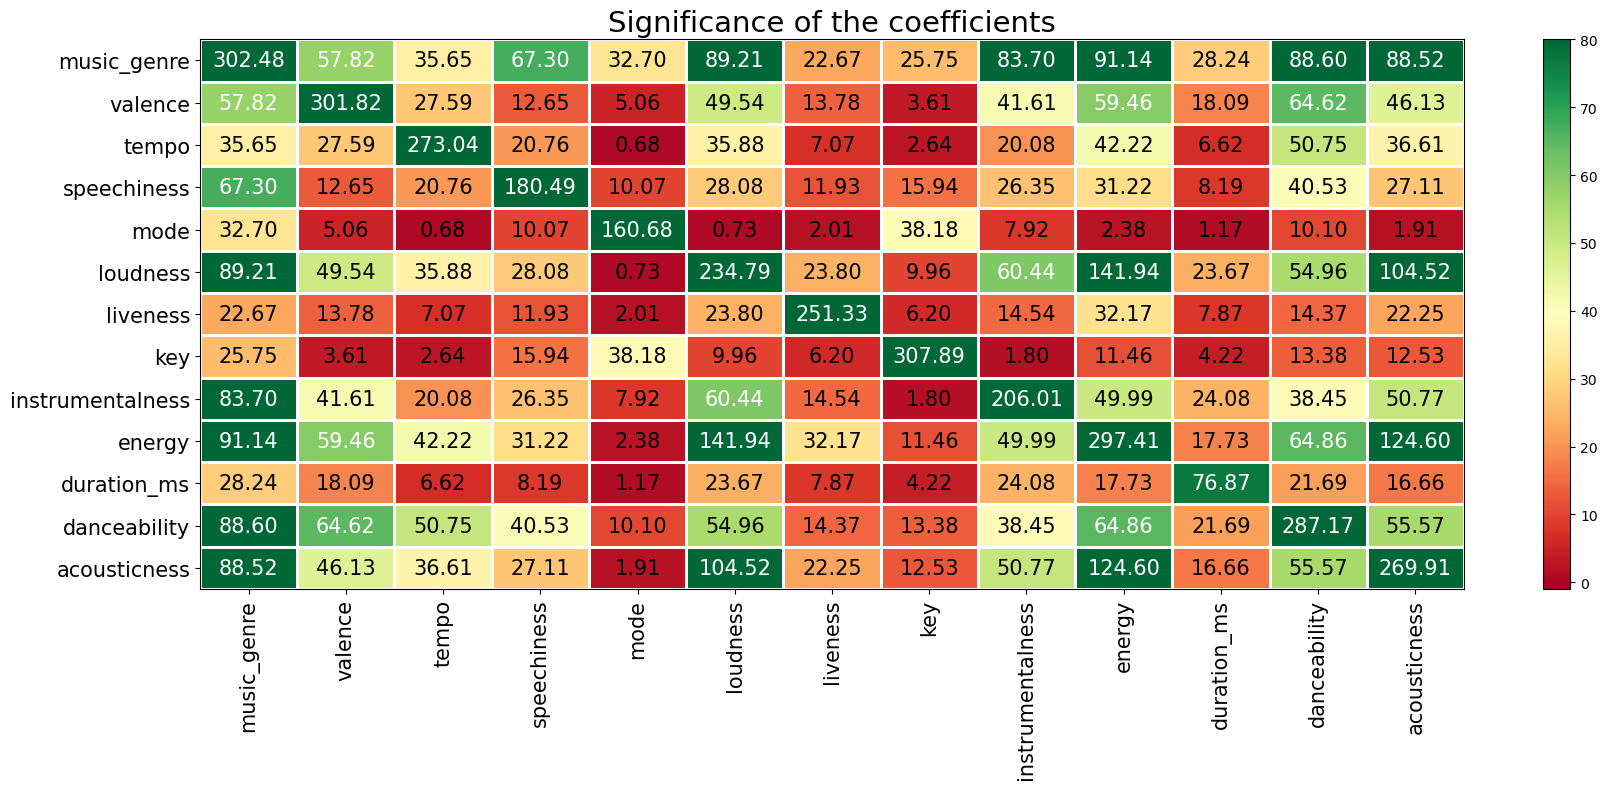

In [15]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

In [16]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


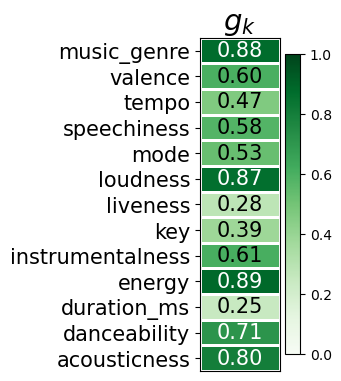

In [17]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

In [18]:
# train['combined_feature'] = (train['energy'] + train['loudness'] + train['acousticness']) / 3
# train = train.drop(['energy', 'loudness', 'acousticness'], axis=1)

Разработка новых синтетических признаков приводит к снижению f1-меры на 0.01 - 0.02 единицы. Поэтому в дальнейшем будем использовать только исходные признаки.

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20387 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20387 non-null  float64
 1   danceability      20387 non-null  float64
 2   duration_ms       20387 non-null  float64
 3   energy            20387 non-null  float64
 4   instrumentalness  20387 non-null  float64
 5   key               19653 non-null  object 
 6   liveness          20387 non-null  float64
 7   loudness          20387 non-null  float64
 8   mode              19881 non-null  object 
 9   speechiness       20387 non-null  float64
 10  tempo             19945 non-null  float64
 11  valence           20387 non-null  float64
 12  music_genre       20387 non-null  object 
dtypes: float64(10), object(3)
memory usage: 2.2+ MB


In [20]:
train.isna().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 734
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
valence               0
music_genre           0
dtype: int64

In [21]:
train['key'].value_counts() 

G     2303
C     2149
C#    2125
D     2109
A     2013
F     1615
B     1521
E     1516
G#    1267
A#    1223
F#    1206
D#     606
Name: key, dtype: int64

In [22]:
train['mode'].value_counts() 

Major    12826
Minor     7055
Name: mode, dtype: int64

In [23]:
train['music_genre'].value_counts() 

Blues          2857
Alternative    2601
Electronic     2559
Rap            2427
Rock           2165
Country        2120
Anime          1901
Classical      1373
Jazz           1239
Hip-Hop        1145
Name: music_genre, dtype: int64

## Подготовка данных к обучению моделей

### Тестируем pipeline

In [24]:
X = train.drop('music_genre', axis=1)
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
num_cols = X.select_dtypes(include='number').columns.tolist()

# Определение шагов пайплайна
num_pipeline = Pipeline(steps=[
    ('impute', IterativeImputer(max_iter=10, random_state=42)),
    ('scale', RobustScaler()),
    ('drop_correlated_features', DropCorrelatedFeatures(threshold=0.8)),
    ('polynomial_features', PolynomialFeatures(degree=2)),
    ('drop_constant_features', DropConstantFeatures(tol=0.998))
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


# Определение ColumnTransformer для обработки числовых и категориальных столбцов
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('cat_pipeline', cat_pipeline, cat_cols)
], remainder='passthrough')

### GridSearchCV

In [25]:
# lr = LogisticRegression(tol=0.01)

# pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', lr)
# ])

# param_dist = {
#     'model__C': np.logspace(-3, 3, 7),
#     'model__penalty': ['l1', 'l2'],
#     'model__solver': ['liblinear', 'saga']
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [26]:
# %%time
# grid.fit(X_train, y_train)

In [27]:
# grid.best_params_

In [28]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Wall time: 2min 56s

{'model__solver': 'liblinear', 'model__penalty': 'l1', 'model__C': 0.1}

0.43

In [29]:
# svc = SVC()

# pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', svc)
# ])

# param_dist = {
#     'model__C': [0.1, 1, 10],
#     'model__kernel': ['linear', 'rbf', 'poly']
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1,
#                     error_score='raise')

In [30]:
# %%time
# grid.fit(X_train, y_train)

In [31]:
# grid.best_params_

In [32]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

In [33]:
# rfc = RandomForestClassifier()

# pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', rfc)
# ])

# param_dist = {
#     'model__n_estimators': [100, 200, 300],
#     'model__max_depth': [None, 5, 10]
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [34]:
# %%time
# grid.fit(X_train, y_train)

In [35]:
# grid.best_params_

In [36]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Wall time: 5min 49s

{'model__n_estimators': 300, 'model__max_depth': 10}

0.44

In [37]:
# mlpc = MLPClassifier()

# pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', mlpc)
# ])

# param_dist = {
#     'model__hidden_layer_sizes': [(100,), (200,), (300,)],
#     'model__activation': ['relu', 'tanh', 'logistic'],
#     'model__alpha': [0.0001, 0.001, 0.01]
# }

# grid = RandomizedSearchCV(pipeline,
#                     param_dist,
#                     n_iter=30,
#                     cv=5,
#                     verbose=5,
#                     random_state=42,
#                     scoring='f1_micro',
#                     n_jobs=-1)

In [38]:
# %%time
# grid.fit(X_train, y_train)

In [39]:
# grid.best_params_

In [40]:
# predicted = grid.predict(X_test)
# f1_score(y_test, predicted, average='micro').round(2)

Wall time: 8min 2s

{'model__hidden_layer_sizes': (100,),
 'model__alpha': 0.01,
 'model__activation': 'logistic'}

 0.3

### PipeLine

In [41]:
cbc = CatBoostClassifier(
    thread_count=4,
    random_strength=1,
    max_ctr_complexity=1,
    learning_rate=0.1,
    l2_leaf_reg=1,
    iterations=300,
    early_stopping_rounds=10,
    depth=4,
    border_count=10,
    bootstrap_type='Bayesian'
)

cbc_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', cbc)
])

cbc_pipeline.fit(X_train, y_train)
y_pred = cbc_pipeline.predict(X_test)

print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

set_config(display='diagram')

0:	learn: 2.1946084	total: 97.8ms	remaining: 29.2s
1:	learn: 2.1224870	total: 135ms	remaining: 20.1s
2:	learn: 2.0698586	total: 158ms	remaining: 15.7s
3:	learn: 2.0242090	total: 183ms	remaining: 13.6s
4:	learn: 1.9877409	total: 287ms	remaining: 16.9s
5:	learn: 1.9521927	total: 319ms	remaining: 15.6s
6:	learn: 1.9216342	total: 376ms	remaining: 15.7s
7:	learn: 1.8998155	total: 405ms	remaining: 14.8s
8:	learn: 1.8721214	total: 447ms	remaining: 14.5s
9:	learn: 1.8498893	total: 486ms	remaining: 14.1s
10:	learn: 1.8300428	total: 507ms	remaining: 13.3s
11:	learn: 1.8098628	total: 526ms	remaining: 12.6s
12:	learn: 1.7937279	total: 546ms	remaining: 12s
13:	learn: 1.7757516	total: 572ms	remaining: 11.7s
14:	learn: 1.7607966	total: 596ms	remaining: 11.3s
15:	learn: 1.7491816	total: 613ms	remaining: 10.9s
16:	learn: 1.7376090	total: 632ms	remaining: 10.5s
17:	learn: 1.7271785	total: 648ms	remaining: 10.1s
18:	learn: 1.7164872	total: 665ms	remaining: 9.83s
19:	learn: 1.7060688	total: 687ms	remainin

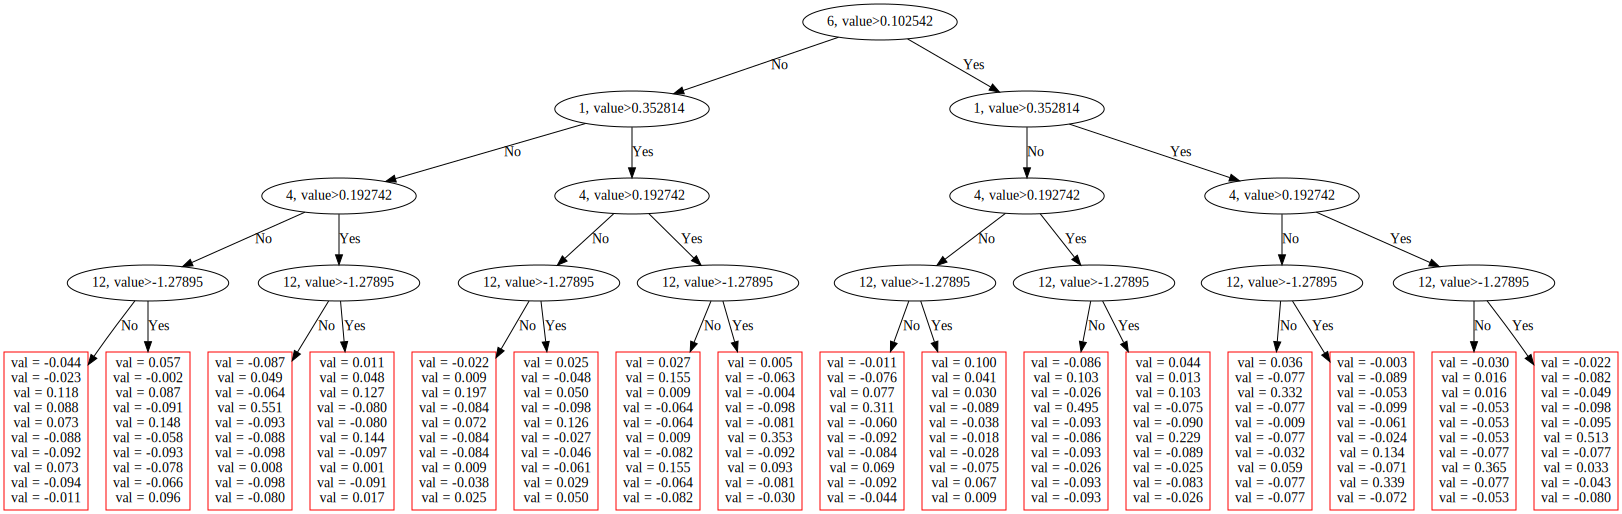

In [42]:
cbc.plot_tree(tree_idx=0)

In [43]:
# lr = LogisticRegression(tol=0.01, solver='liblinear', penalty='l1', C=0.1)
# lr_pipeline = Pipeline(steps=[
#     ('col_trans', col_trans),
#     ('model', lr)
# ])

# lr_pipeline.fit(X_train, y_train)
# y_pred = lr_pipeline.predict(X_test)

# print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

In [44]:
# rfc = RandomForestClassifier(n_estimators=300, max_depth=10)

# rfc_pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', rfc)
# ])

# rfc_pipeline.fit(X_train, y_train)
# y_pred = rfc_pipeline.predict(X_test)

# print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

In [45]:
# mlpc = MLPClassifier(hidden_layer_sizes=(100,),
#                     alpha=0.01,
#                     activation='logistic')

# mlpc_pipeline = Pipeline(steps=[
#     ('pipeline', col_trans),
#     ('model', mlpc)
# ])

# mlpc_pipeline.fit(X_train, y_train)
# y_pred = mlpc_pipeline.predict(X_test)

# print('f1_micro =', f1_score(y_test, y_pred, average='micro').round(2))

## Проводим финальное тестирование

In [46]:
try:
    test = pd.read_csv('kaggle_music_genre_test.csv')
except:
    train = pd.read_csv('/kaggle/input/the-kaggle-music-prediction-competition/kaggle_music_genre_train.csv')


In [47]:
tes1 = test

In [48]:
test = test.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [51]:
y_pred = cbc_pipeline.predict(test)

y_pred = y_pred.ravel().tolist()
# Создание столбца с предсказаниями
y_pred_series = pd.Series(y_pred, name='music_genre')

# Создание столбца с instance_id
instance_id_column = tes1['instance_id']

# Создание DataFrame из столбцов
submit = pd.concat([instance_id_column, y_pred_series], axis=1)

# Сохранение DataFrame с предсказаниями в файл
submit.to_csv('cbc_pipeline.csv', index=False)